In [226]:
import pickle

data_list = range(493,499)
for data_number in data_list:
    with open('../data/both57m_rigged/%d.pkl' % data_number, 'rb') as f:
        data = pickle.load(f)
    
    full_annot = data['full_annot']
    print(data_number, full_annot,"\n")

# (267,271:70,500) (493,499:38) (832,836:310)

493 ['a person places their left hand on their waist and points their right index finger outward to indicate engaging in conversation with someone.'
 'a person puts their left hand on their waist to indicate a relaxed state.'
 'a person expresses their relaxation by placing their hands on their waist.'] 

494 ['the person crosses their arms in front of their chest to indicate refusal.'
 'a person crosses their arms in front of their chest to indicate refusal.'
 'a person crosses their arms to express resistance.'] 

495 ['a person points forward with their index finger to indicate direction to others.'
 'a person points their finger towards someone to indicate being in conversation.'
 'a person uses their finger to indicate that they are speaking.'] 

496 ['a person points at someone with their finger to indicate giving a hint to someone.'
 'a person uses their finger to indicate and point out a problem.'
 'when one person wants to give guidance to others, they use their finger to poin

In [227]:
import torch,sys,pickle
import numpy as np
sys.path.append('../utils')
from mujoco_parser import MuJoCoParserClass
from util import rpy2r,get_idxs,np_uv
from smplx import MANO

comp_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
xml_path = '../asset/smplh_rig/scene_smplh_rig.xml'
env = MuJoCoParserClass(name='Common-Rig',rel_xml_path=xml_path,VERBOSE=False)
left_mano_path = '../models/mano_models/MANO_LEFT.pkl'
right_mano_path = '../models/mano_models/MANO_RIGHT.pkl'

left_model = MANO(model_path=left_mano_path,is_rhand=False,use_pca=False,flat_hand_mean=True).to(comp_device)
right_model = MANO(model_path=right_mano_path,is_rhand=True,use_pca=False,flat_hand_mean=True).to(comp_device)

smplh_right_shoulder_pos = env.get_p_joint('r_shoulder1')
smplh_right_wrist_pos = env.get_p_joint('r_wrist1')
smplh_left_shoulder_pos = env.get_p_joint('l_shoulder1')
smplh_arm_length = np.linalg.norm(smplh_right_shoulder_pos-smplh_right_wrist_pos)

# Modify the color of body exluding 'world'
for body_name in env.body_names:
    if body_name in ['world']: continue
    for geom_idx in env.get_geom_idxs_from_body_name(body_name=body_name):
        env.model.geom(geom_idx).rgba = [0.3,0.3,0.5,0.5]

In [228]:
data_numbers = range(98,101)
ZERO_ROOT = True

video = []
tick = 0
seq_len = 0

qpos_rig_data = np.empty((0,env.model.nq))
left_joint_pos_array_full = np.empty((0,21,3))
right_joint_pos_array_full = np.empty((0,21,3))

mano2mp = [0,17,18,19,20,1,2,3,4,5,6,7,8,13,14,15,16,9,10,11,12]
MANO_LEFT_UP = np.array([[0, -1, 0],[0, 0, -1],[1, 0, 0]])
MANO_RIGHT_UP = np.array([[0, -1, 0],[0, 0, 1],[-1, 0, 0]])

for data_number in data_numbers:
    with open('../data/both57m_rigged/%d.pkl' % data_number, 'rb') as f:
        data = pickle.load(f)

    qpos_rig_data = np.concatenate((qpos_rig_data, data['qpos']), axis=0)
    seq_len += data['length']

    hand_data_path = '../data/both57m/%d/data.npz'%(data_number)
    hand_data = np.load(hand_data_path)
    hand_seq_len = hand_data['seq_len']

    hand_pose = torch.Tensor(hand_data['hand_pose'].reshape((hand_seq_len,-1))).to(comp_device)
    left_hand_pose = hand_pose[:,:45]
    right_hand_pose = hand_pose[:,45:]

    left_joint_pos_list = []
    right_joint_pos_list = []
    left_extra_joints_idxs = left_model.vertex_joint_selector.extra_joints_idxs
    right_extra_joints_idxs = right_model.vertex_joint_selector.extra_joints_idxs
    finger_idxs = [0,1,2,3,5,6,7,9,10,11,13,14,15,17,18,19]
    fingertip_idxs = [20,4,8,16,12]

    for i in range(hand_seq_len):
        left_output = left_model(hand_pose=left_hand_pose[i].unsqueeze(0),return_verts=True)
        left_finger_pos_output = left_output.joints.detach().cpu().numpy().squeeze()
        left_fingertip_pos_output = left_output.vertices[:,left_extra_joints_idxs,:].detach().cpu().numpy().squeeze()
        left_full_joint_pos = np.zeros((21,3))
        left_full_joint_pos[finger_idxs] = left_finger_pos_output
        left_full_joint_pos[fingertip_idxs] = left_fingertip_pos_output
        left_joint_pos_list.append(left_full_joint_pos)

        right_output = right_model(hand_pose=right_hand_pose[i].unsqueeze(0),return_verts=True)
        right_finger_pos_output = right_output.joints.detach().cpu().numpy().squeeze()
        right_fingertip_pos_output = right_output.vertices[:,right_extra_joints_idxs,:].detach().cpu().numpy().squeeze()
        right_full_joint_pos = np.zeros((21,3))
        right_full_joint_pos[finger_idxs] = right_finger_pos_output
        right_full_joint_pos[fingertip_idxs] = right_fingertip_pos_output
        right_joint_pos_list.append(right_full_joint_pos)

    left_joint_pos_array = np.array(left_joint_pos_list)[:,mano2mp]
    right_joint_pos_array = np.array(right_joint_pos_list)[:,mano2mp]

    for i in range(hand_seq_len):
        left_joint_pos_array[i] = np.matmul(MANO_LEFT_UP,left_joint_pos_array[i].T).T
        right_joint_pos_array[i] = np.matmul(MANO_RIGHT_UP,right_joint_pos_array[i].T).T

    left_joint_pos_array_full = np.concatenate((left_joint_pos_array_full, left_joint_pos_array), axis=0)
    right_joint_pos_array_full = np.concatenate((right_joint_pos_array_full, right_joint_pos_array), axis=0)

In [229]:
start_tick = 0
end_tick = seq_len
final_len = end_tick - start_tick

ls2le_array = np.zeros((final_len,3))
le2lw_array = np.zeros((final_len,3))
rs2re_array = np.zeros((final_len,3))
re2rw_array = np.zeros((final_len,3))
lw_rot_array = np.zeros((final_len,3,3))
rw_rot_array = np.zeros((final_len,3,3))
lh_array = np.zeros((final_len,6))
rh_array = np.zeros((final_len,6))

left_joint_pos_array_full = left_joint_pos_array_full[start_tick:end_tick]
right_joint_pos_array_full = right_joint_pos_array_full[start_tick:end_tick]

while tick < end_tick-start_tick:
    q_rig = qpos_rig_data[tick+start_tick,:]
    coupled_joint_idxs_list = [[47,48],[31,32,33],[34,35,36],[42,43,44],[38,39,40],[41,37],
                                [74,75],[58,59,60],[61,62,63],[65,66,67],[69,70,71],[68,64]]

    coupled_joint_weights_list = [[1,1],[1,3,2],[1,3,2],[1,3,2],[1,3,2],[2,5],
                                    [1,1],[1,3,2],[1,3,2],[1,3,2],[1,3,2],[2,5]]
    
    q_couple = env.get_q_couple(
        q_raw=q_rig,
        coupled_joint_idxs_list=coupled_joint_idxs_list,
        coupled_joint_weights_list=coupled_joint_weights_list)

    if ZERO_ROOT:
        q_rig[3:7] = 0
    
    env.forward(q=q_rig,INCREASE_TICK=True)
    ls = env.get_p_body('left_shoulder')
    le = env.get_p_body('left_elbow')
    lw = env.get_p_body('left_wrist')
    rs = env.get_p_body('right_shoulder')
    re = env.get_p_body('right_elbow')
    rw = env.get_p_body('right_wrist')

    ls2le_array[tick,:] = np_uv(le-ls)
    le2lw_array[tick,:] = np_uv(lw-le)
    rs2re_array[tick,:] = np_uv(re-rs)
    re2rw_array[tick,:] = np_uv(rw-re)
    lw_rot_array[tick,:] = env.get_R_body('left_wrist')
    rw_rot_array[tick,:] = env.get_R_body('right_wrist')
    tick = tick + 1

In [230]:
SAVE_VIDEO = True
vis_tick = 0

# Initialize MuJoCo viewer
env.init_viewer(viewer_title='SMPLH-Rig',viewer_width=800,viewer_height=800,
                viewer_hide_menus=True)
env.update_viewer(azimuth=180,distance=3.0,elevation=-20,lookat=[0.02,-0.03,1.2])
env.reset()

while vis_tick < final_len:
    q_rig = qpos_rig_data[vis_tick+start_tick,:]
    env.forward(q=q_rig,INCREASE_TICK=True)

    # Plot world frame
    env.plot_T(p=np.zeros(3),R=np.eye(3,3),
                PLOT_AXIS=True,axis_len=0.5,axis_width=0.005)
    env.plot_T(p=np.array([0,0,0.5]),R=np.eye(3,3),
                PLOT_AXIS=False,label="tick:[%d/%d]"%(vis_tick,final_len))
    env.render()  
    frame = env.grab_image()
    video.append(frame)

    for rev_joint_idx,rev_joint_name in zip(env.rev_joint_idxs,env.rev_joint_names):
        axis_joint = env.model.jnt_axis[rev_joint_idx]
        p_joint,R_joint = env.get_pR_joint(joint_name=rev_joint_name)
        axis_world = R_joint@axis_joint
        axis_rgba = np.append(np.eye(3)[:,np.argmax(axis_joint)],0.2)
        axis_len,axis_r = 0.02,0.002
        env.plot_arrow_fr2to(
            p_fr=p_joint,p_to=p_joint+axis_len*axis_world,
            r=axis_r,rgba=axis_rgba)

    vis_tick = vis_tick + 1
    if vis_tick == final_len:
        if not SAVE_VIDEO: vis_tick = 0

env.close_viewer()

if SAVE_VIDEO:
    import mediapy as media
    media.show_video(images=video,fps=15,width=700)

In [231]:
recon_tick = 0

# Initialize MuJoCo viewer
env.init_viewer(viewer_title='SMPLH-Rig',viewer_width=800,viewer_height=800,
                viewer_hide_menus=True)
env.update_viewer(azimuth=180,distance=3.0,elevation=-20,lookat=[0.02,-0.03,1.2])
env.reset()

BODY_NAMES = ['left_elbow','left_wrist','right_elbow','right_wrist']
JOINT_NAMES = ['l_shoulder1', 'l_shoulder2', 'l_shoulder3', 'l_elbow', 'l_wrist1', 'l_wrist2', 'l_wrist3',
               'r_shoulder1', 'r_shoulder2', 'r_shoulder3', 'r_elbow', 'r_wrist1', 'r_wrist2', 'r_wrist3']

hand_indices = list(range(27,49)) + list(range(54,76))
video = []
wrist_dist_list = []
smplh_lw_pos_list = []
smplh_rw_pos_list = []
q_smplh_up_list = []

ls = env.get_p_body('left_shoulder')
le = env.get_p_body('left_elbow')
lw = env.get_p_body('left_wrist')
rs = env.get_p_body('right_shoulder')
re = env.get_p_body('right_elbow')
rw = env.get_p_body('right_wrist')

len_ls2le = np.linalg.norm(le-ls)
len_le2lw = np.linalg.norm(lw-le)
len_rs2re = np.linalg.norm(re-rs)
len_re2rw = np.linalg.norm(rw-re)

while recon_tick < final_len:
    p_target = {}
    p_target['left_elbow'] = ls + len_ls2le * ls2le_array[recon_tick,:]
    p_target['left_wrist'] = p_target['left_elbow'] + len_le2lw * le2lw_array[recon_tick,:]
    p_target['right_elbow'] = rs + len_rs2re * rs2re_array[recon_tick,]
    p_target['right_wrist'] = p_target['right_elbow'] + len_re2rw * re2rw_array[recon_tick,:]
    
    idxs = get_idxs(env.rev_joint_names,JOINT_NAMES)
    q_mins_body,q_maxs_body = env.rev_joint_mins[idxs],env.rev_joint_maxs[idxs]
    joint_idxs_fwd_body = env.get_idxs_fwd(joint_names=JOINT_NAMES)
    joint_idxs_jac_body = env.get_idxs_jac(joint_names=JOINT_NAMES)

    q_body = env.get_qpos_joints(JOINT_NAMES)
    body_diff = 1e3
    prev_q_pos = env.data.qpos.copy()

    while body_diff > 1e-4:
        for ik_tick in range(1):
            J_list,ik_err_list = [],[]
            for ik_body_name in BODY_NAMES:
                ik_p_trgt = p_target[ik_body_name]
                ik_R_trgt = None
                IK_P = True
                IK_R = False
                J,ik_err = env.get_ik_ingredients(
                    body_name=ik_body_name,p_trgt=ik_p_trgt,R_trgt=ik_R_trgt,
                    IK_P=IK_P,IK_R=IK_R)
                J_list.append(J)
                ik_err_list.append(ik_err)
            J_stack      = np.vstack(J_list)
            ik_err_stack = np.hstack(ik_err_list)
            dq = env.damped_ls(J_stack,ik_err_stack,stepsize=1,eps=1e-2,th=np.radians(1.0))
            q_body = q_body + dq[joint_idxs_jac_body]

            q_body = np.clip(q_body,q_mins_body,q_maxs_body)
            env.forward(q=q_body,joint_idxs=joint_idxs_fwd_body)

            q_env = env.data.qpos.copy()
            body_diff = np.linalg.norm(q_env - prev_q_pos)
            prev_q_pos=q_env.copy()

    q_rig = qpos_rig_data[recon_tick+start_tick,:]
    q_env[hand_indices] = q_rig[hand_indices]
    env.forward(q=q_env,INCREASE_TICK=True)
    q_smplh_up_list.append(q_env)

    left_wrist_pos = env.get_p_body('left_wrist')
    right_wrist_pos = env.get_p_body('right_wrist')
    smplh_lw_pos_list.append(left_wrist_pos)
    smplh_rw_pos_list.append(right_wrist_pos)
    wrist_dist = np.linalg.norm(left_wrist_pos - right_wrist_pos)
    wrist_dist_list.append(wrist_dist)
    wrist_pos = np.vstack((left_wrist_pos,right_wrist_pos))

    env.plot_T(p=np.zeros(3),R=np.eye(3),label="Tick: [%d/%d]"%(recon_tick,final_len),axis_len=0.5,axis_width=0.005)
    env.plot_traj(wrist_pos,rgba=[0,0,1,1],plot_line=True,plot_sphere=True,sphere_r=0.005)
    env.render()

    video.append(env.grab_image())
    recon_tick += 1

q_smplh_up_array = np.array(q_smplh_up_list)
env.close_viewer()
media.show_video(images=video,fps=15,width=700)

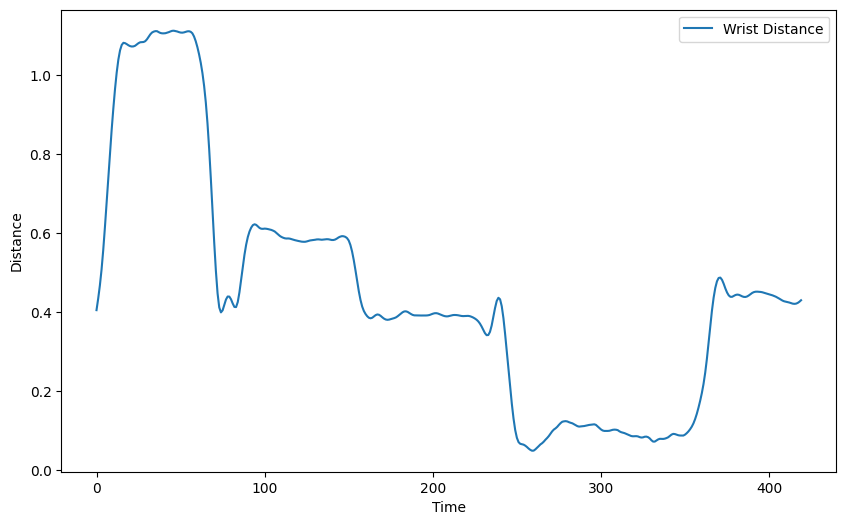

In [232]:
wrist_dist_array = np.array(wrist_dist_list)

import matplotlib.pyplot as plt

time = np.arange(0,wrist_dist_array.shape[0])
plt.figure(figsize=(10,6))
plt.plot(time, wrist_dist_array,label='Wrist Distance')

plt.xlabel('Time')
plt.ylabel('Distance')
plt.legend()

plt.show()

In [233]:
sys.path.append('../ability_hand')
from pathlib import Path

from dex_retargeting.constants import RobotName, RetargetingType, HandType, get_default_config_path
from dex_retargeting.retargeting_config import RetargetingConfig

robot_name = RobotName.ability
retargeting_type = RetargetingType.dexpilot
robot_dir = Path().absolute().parent / "ability_hand" / "assets" 
RetargetingConfig.set_default_urdf_dir(str(robot_dir))

hand_type_left = HandType.left
config_path = get_default_config_path(robot_name, retargeting_type, hand_type_left)
left_retargeting = RetargetingConfig.load_from_file(config_path).build()

left_ability_joints_list = []
right_ability_joints_list = []

for i in range(final_len):
    retargeting_type = left_retargeting.optimizer.retargeting_type
    indices = left_retargeting.optimizer.target_link_human_indices
    origin_indices = indices[0, :]
    task_indices = indices[1, :]
    
    left_joint_pos = left_joint_pos_array_full[i]
    ref_value = left_joint_pos[task_indices, :] - left_joint_pos[origin_indices, :]
    left_qpos = left_retargeting.retarget(ref_value)
    left_ability_joints_list.append(left_qpos)

left_joint_names=left_retargeting.optimizer.robot.dof_joint_names
left_ability_joints_array = np.array(left_ability_joints_list)

hand_type_right = HandType.right
config_path = get_default_config_path(robot_name, retargeting_type, hand_type_right)
right_retargeting = RetargetingConfig.load_from_file(config_path).build()

for i in range(final_len):
    retargeting_type = right_retargeting.optimizer.retargeting_type
    indices = right_retargeting.optimizer.target_link_human_indices
    origin_indices = indices[0, :]
    task_indices = indices[1, :]

    right_joint_pos = right_joint_pos_array_full[i]
    ref_value = right_joint_pos[task_indices, :] - right_joint_pos[origin_indices, :]
    right_qpos = right_retargeting.retarget(ref_value)
    right_ability_joints_list.append(right_qpos)

right_joint_names=right_retargeting.optimizer.robot.dof_joint_names
right_ability_joints_array = np.array(right_ability_joints_list)

 Mimic joint adaptor enabled. The mimic joint tags in the URDF will be considered during retargeting.
To disable mimic joint adaptor, consider setting ignore_mimic_joint=True in the configuration. 
 Mimic joint adaptor enabled. The mimic joint tags in the URDF will be considered during retargeting.
To disable mimic joint adaptor, consider setting ignore_mimic_joint=True in the configuration. 


In [234]:
xml_path = '../asset/kimlab_dualarms/scene_dualarms.xml'
env = MuJoCoParserClass(name='Dual Arms',rel_xml_path=xml_path,VERBOSE=False)
env.set_geom_color(
    rgba                = (0.2,0.2,0.2,0.9),
    body_names_to_color = [
        'robot1/end_link','robot1/index_L1','robot1/index_L2','robot1/index_tip',
        'robot1/middle_L1','robot1/middle_L2','robot1/middle_tip',
        'robot1/ring_L1','robot1/ring_L2','robot1/ring_tip',
        'robot1/pinky_L1','robot1/pinky_L2','robot1/pinky_tip',
        'robot1/thumb_L1','robot1/thumb_L2','robot1/thumb_tip',
        'robot2/end_link','robot2/index_L1','robot2/index_L2','robot2/index_tip',
        'robot2/middle_L1','robot2/middle_L2','robot2/middle_tip',
        'robot2/ring_L1','robot2/ring_L2','robot2/ring_tip',
        'robot2/pinky_L1','robot2/pinky_L2','robot2/pinky_tip',
        'robot2/thumb_L1','robot2/thumb_L2','robot2/thumb_tip'],
)

q_init = env.data.qpos.copy()
q_init[18] = -np.pi/2
env.forward(q=q_init)

robot_right_shoulder_pos = env.get_p_joint('robot2/joint1')
robot_right_wrist_pos = env.get_p_joint('robot2/joint6')
robot_left_shoulder_pos = env.get_p_joint('robot1/joint1')

robot_arm_length = np.linalg.norm(robot_right_shoulder_pos-robot_right_wrist_pos)
print ("Done.")

Done.


In [235]:
from tqdm import tqdm

env.init_viewer(viewer_title='Dual Arms',viewer_width=800,viewer_height=800,viewer_hide_menus=True)
env.update_viewer(azimuth=180,distance=3.0,elevation=-20,lookat=[0.02,-0.03,1.2])
env.reset()

BODY_NAMES = ['robot1/end_link','robot2/end_link']
JOINT_NAMES = ['robot1/joint1','robot1/joint2','robot1/joint3','robot1/joint4','robot1/joint5','robot1/joint6',
               'robot2/joint1','robot2/joint2','robot2/joint3','robot2/joint4','robot2/joint5','robot2/joint6']

ls = env.get_p_body('robot1/link2')
le = env.get_p_body('robot1/link4')
lw = env.get_p_body('robot1/link6')
rs = env.get_p_body('robot2/link2')
re = env.get_p_body('robot2/link4')
rw = env.get_p_body('robot2/link6')

len_ls2le = np.linalg.norm(le-ls)
len_le2lw = np.linalg.norm(lw-le)
len_rs2re = np.linalg.norm(re-rs)
len_re2rw = np.linalg.norm(rw-re)

q_env_array = np.zeros((final_len,env.model.nq))

for tick in tqdm(range(final_len), desc="Processing"):
    p_target = {}
    p_target['robot1/end_link'] = ls + len_ls2le * ls2le_array[tick,:] + len_le2lw * le2lw_array[tick,:]
    p_target['robot2/end_link'] = rs + len_rs2re * rs2re_array[tick,:] + len_re2rw * re2rw_array[tick,:]
    R_target = {}
    R_target['robot1/end_link'] = lw_rot_array[tick,:] @ rpy2r(np.radians([0,0,90]))
    R_target['robot2/end_link'] = rw_rot_array[tick,:] @ rpy2r(np.radians([0,0,-90]))

    idxs = get_idxs(env.rev_joint_names,JOINT_NAMES)
    q_mins_body,q_maxs_body = env.rev_joint_mins[idxs],env.rev_joint_maxs[idxs]
    joint_idxs_fwd_body = env.get_idxs_fwd(joint_names=JOINT_NAMES)
    joint_idxs_jac_body = env.get_idxs_jac(joint_names=JOINT_NAMES)

    q_body = env.get_qpos_joints(JOINT_NAMES)
    body_diff = 1e3
    prev_q_pos = env.data.qpos.copy()

    while body_diff > 1e-4:
        for ik_tick in range(1):
            J_list,ik_err_list = [],[]
            for ik_body_name in BODY_NAMES:
                ik_p_trgt = p_target[ik_body_name]
                ik_R_trgt = R_target[ik_body_name]
                IK_P = True
                IK_R = True
                J,ik_err = env.get_ik_ingredients(
                    body_name=ik_body_name,p_trgt=ik_p_trgt,R_trgt=ik_R_trgt,
                    IK_P=IK_P,IK_R=IK_R)
                J_list.append(J)
                ik_err_list.append(ik_err)
            J_stack      = np.vstack(J_list)
            ik_err_stack = np.hstack(ik_err_list)
            dq = env.damped_ls(J_stack,ik_err_stack,stepsize=1,eps=1e-2,th=np.radians(1.0))
            q_body = q_body + dq[joint_idxs_jac_body]

            q_body = np.clip(q_body,q_mins_body,q_maxs_body)
            env.forward(q=q_body,joint_idxs=joint_idxs_fwd_body)

            q_env = env.data.qpos.copy()
            body_diff = np.linalg.norm(q_env - prev_q_pos)
            prev_q_pos=q_env.copy()

    q_env_array[tick,:] = q_env
    # env.render()

env.close_viewer()

Processing: 100%|██████████| 420/420 [00:32<00:00, 13.10it/s]


In [236]:
import mediapy

env.init_viewer(viewer_title='Dual-Arm',viewer_width=800,viewer_height=800,
                viewer_hide_menus=True)
env.update_viewer(azimuth=180,distance=3.0,elevation=-20,lookat=[0.02,-0.03,1.2])
env.reset()

SAVE_VIDEO = True

video = []
robot_wrist_dist_list = []
plot_tick = 0

left_hand_joint_names = ['robot1/' + i for i in left_joint_names]
left_hand_idxs = get_idxs(env.joint_names,left_hand_joint_names)
right_hand_joint_names = ['robot2/' + i for i in right_joint_names]
right_hand_idxs = get_idxs(env.joint_names,right_hand_joint_names)
hand_idxs = np.concatenate((left_hand_idxs,right_hand_idxs))

q_robot_array = np.zeros((final_len,env.model.nq))

while plot_tick < final_len and env.is_viewer_alive():
    p_target = {}
    p_target['robot1/end_link'] = ls + len_ls2le * ls2le_array[plot_tick,:] + len_le2lw * le2lw_array[plot_tick,:]
    p_target['robot2/end_link'] = rs + len_rs2re * rs2re_array[plot_tick,:] + len_re2rw * re2rw_array[plot_tick,:]
    R_target = {}
    R_target['robot1/end_link'] = lw_rot_array[plot_tick,:] 
    R_target['robot2/end_link'] = rw_rot_array[plot_tick,:] @ rpy2r(np.radians([0,0,-90]))

    q_robot = q_env_array[plot_tick,:]
    left_ability_joints = left_ability_joints_array[plot_tick]
    right_ability_joints = right_ability_joints_array[plot_tick]
    ability_joints = np.concatenate((left_ability_joints,right_ability_joints))
    q_robot[hand_idxs] = ability_joints
    env.forward(q=q_robot,INCREASE_TICK=True)

    robot_left_wrist_pos = env.get_p_body('robot1/end_link')
    robot_right_wrist_pos = env.get_p_body('robot2/end_link')
    robot_wrist_dist = np.linalg.norm(robot_left_wrist_pos - robot_right_wrist_pos)
    robot_wrist_dist_list.append(robot_wrist_dist)
    robot_wrist_pos = np.vstack((robot_left_wrist_pos,robot_right_wrist_pos))

    env.plot_T(p=np.zeros(3),R=np.eye(3),label="Tick: [%d/%d]"%(plot_tick,final_len),axis_len=0.5,axis_width=0.005)
    env.plot_traj(robot_wrist_pos,rgba=[1,0,0,1],plot_line=True,plot_sphere=True,sphere_r=0.005)
    env.render()

    q_robot_array[plot_tick,:] = env.data.qpos.copy()
    video.append(env.grab_image())
    plot_tick += 1
    if plot_tick == final_len:
        if not SAVE_VIDEO: plot_tick = 0

env.close_viewer()
if SAVE_VIDEO:mediapy.show_video(images=video,fps=15,width=700)

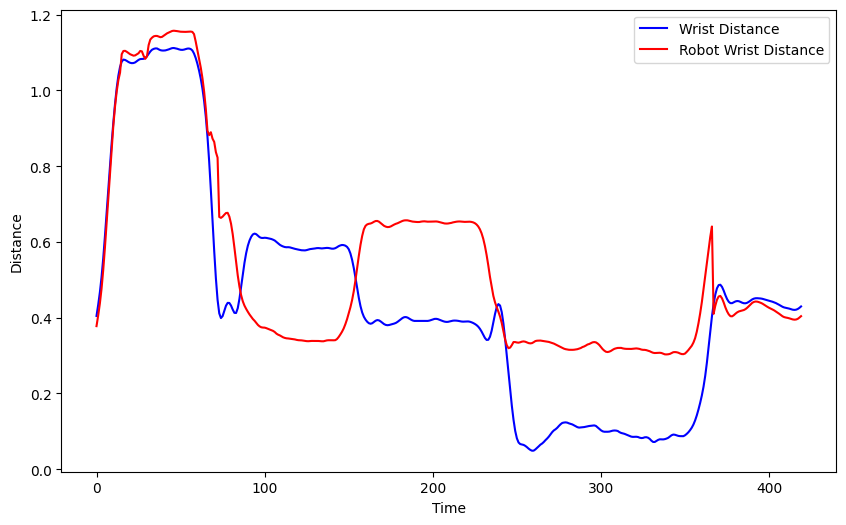

In [237]:
robot_wrist_dist_array = np.array(robot_wrist_dist_list)

import matplotlib.pyplot as plt

time = np.arange(0, robot_wrist_dist_array.shape[0])
plt.figure(figsize=(10, 6))
plt.plot(time, wrist_dist_array, 'b-', label='Wrist Distance')
plt.plot(time, robot_wrist_dist_array, 'r-', label='Robot Wrist Distance')

plt.xlabel('Time')
plt.ylabel('Distance')
plt.legend()

plt.show()

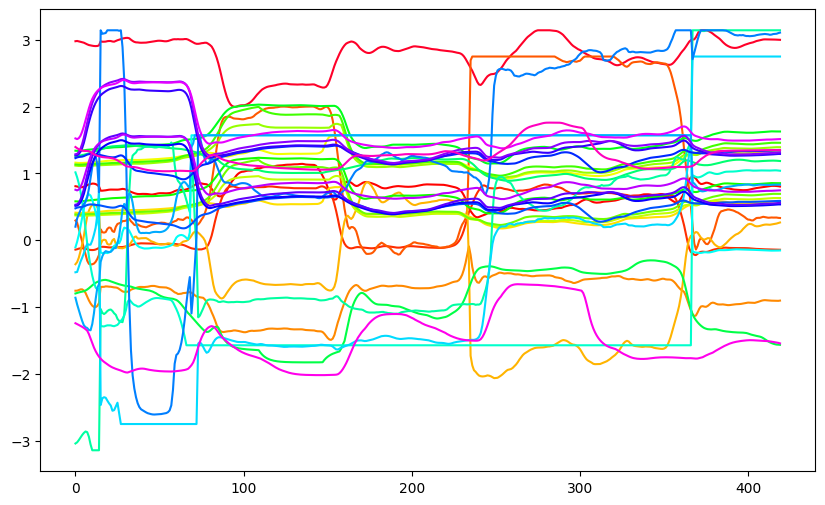

In [238]:
import matplotlib.pyplot as plt

time = np.arange(0,q_robot_array.shape[0])
plt.figure(figsize=(10,6))
cs = [plt.cm.gist_rainbow(x) for x in np.linspace(0,1,q_robot_array.shape[1])]
for i in range(q_robot_array.shape[1]):
    plt.plot(time, q_robot_array[:,i], color=cs[i])

In [239]:
import mujoco,time
sys.path.append('../utils')
from mujoco_parser import init_ik_info,add_ik_info,get_dq_from_ik_info
from utility import smooth_optm_1d

joint_names_for_ik = env.rev_joint_names
collision_push_len = 0.0005
gap_per_step_cm = 0.0005
max_gap_cm = 2.0
acc_limit = 500
max_ik_tick = 100
body_name_to_exlude = "world"
left_hand_names = ['robot1/end_link',
    'robot1/index_L1', 'robot1/index_L2', 'robot1/index_tip', 
    'robot1/middle_L1', 'robot1/middle_L2', 'robot1/middle_tip',
    'robot1/ring_L1', 'robot1/ring_L2', 'robot1/ring_tip',
    'robot1/pinky_L1', 'robot1/pinky_L2', 'robot1/pinky_tip',
    'robot1/thumb_L1', 'robot1/thumb_L2', 'robot1/thumb_tip',
    ]
right_hand_names = ['robot2/end_link',
    'robot2/index_L1', 'robot2/index_L2', 'robot2/index_tip',
    'robot2/middle_L1', 'robot2/middle_L2', 'robot2/middle_tip',
    'robot2/ring_L1', 'robot2/ring_L2', 'robot2/ring_tip',
    'robot2/pinky_L1', 'robot2/pinky_L2', 'robot2/pinky_tip',
    'robot2/thumb_L1', 'robot2/thumb_L2', 'robot2/thumb_tip'
    ]

L = final_len
qpos_array = q_robot_array.copy()
qpos_init_array = qpos_array.copy()

ch_step = 0
while True:
    if ch_step == 35:
        collision_push_len /= 5
        gap_per_step_cm /= 5
    collision_gap_cm = ch_step * gap_per_step_cm
    if collision_gap_cm > max_gap_cm:
        collision_gap_cm = max_gap_cm
    env.model.geom_gap = collision_gap_cm / 100
    env.model.geom_margin = collision_gap_cm / 100

    qpos_cf_list = []
    n_sc = 0
    time_bc = time.time()

    for tick in range(L):
        env.forward(q=qpos_array[tick,:])
        sc_occured = False

        for ik_tick in range(max_ik_tick):
            p_contact_list,f_contact_list = [],[]
            contact_body1_list, contact_body2_list = [],[]
            
            for c_idx in range(env.data.ncon):
                contact = env.data.contact[c_idx]
                p_contact = contact.pos
                R_frame = contact.frame.reshape((3,3))

                f_contact_local = np.zeros(6,dtype=np.float64)
                mujoco.mj_contactForce(env.model,env.data,0,f_contact_local)
                f_contact = R_frame @ f_contact_local[:3]
                f_contact = np_uv(f_contact)

                contact_body1 = env.body_names[env.model.geom_bodyid[contact.geom1]]
                contact_body2 = env.body_names[env.model.geom_bodyid[contact.geom2]]

                if (contact_body1==body_name_to_exlude) or (contact_body2==body_name_to_exlude):
                    continue

                if (contact_body1 in left_hand_names) and (contact_body2 in left_hand_names):
                    continue

                if (contact_body1 in right_hand_names) and (contact_body2 in right_hand_names):
                    continue

                # print("Contact between [%s] and [%s] at tick [%d]"%(contact_body1,contact_body2,tick))

                p_contact_list.append(p_contact)
                f_contact_list.append(f_contact)
                contact_body1_list.append(contact_body1)
                contact_body2_list.append(contact_body2)

            ik_info_collision = init_ik_info()
            n_contact = len(p_contact_list)

            if n_contact > 0:
                sc_occured = True
                for c_idx in range(n_contact):
                    f_contact = f_contact_list[c_idx]
                    contact_body1 = contact_body1_list[c_idx]
                    contact_body2 = contact_body2_list[c_idx]
                    p_body1 = env.get_p_body(body_name=contact_body1)
                    p_body2 = env.get_p_body(body_name=contact_body2)

                    add_ik_info(
                        ik_info = ik_info_collision,
                        body_name = contact_body1,
                        p_trgt = p_body1 - collision_push_len * np_uv(f_contact)   
                    )
                    add_ik_info(
                        ik_info = ik_info_collision,
                        body_name = contact_body2,
                        p_trgt = p_body2 + collision_push_len * np_uv(f_contact)
                    )
                
                joint_idxs_jac_collision = env.get_idxs_jac(joint_names=joint_names_for_ik)
                dq,ik_err_stack = get_dq_from_ik_info(
                    env=env,
                    ik_info=ik_info_collision,
                    stepsize=1,
                    eps=1e-2,
                    th=np.radians(3.0),
                    joint_idxs_jac=joint_idxs_jac_collision,
                )

                qpos = env.data.qpos.copy()
                mujoco.mj_integratePos(env.model,qpos,dq,1)
                qpos = np.clip(qpos,env.model.jnt_range[:,0],env.model.jnt_range[:,1])
                env.forward(q=qpos)

            else:
                break
        
        if sc_occured: n_sc = n_sc + 1
        qpos_cf_list.append(env.data.qpos.copy())

    time_ac = time.time()
    print ("[%d] [step-1:collision handling] n_sc:[%d] collision_gap:[%.2f]cm time taken:[%f]s"%(ch_step,n_sc,collision_gap_cm,time_ac-time_bc))

    time_bs = time.time()
    qpos_cf_array = np.array(qpos_cf_list)
    qpos_cf_smt_array = qpos_cf_array.copy()

    for d_idx in env.get_idxs_fwd(joint_names=joint_names_for_ik):
        qpos_cf_smt_array[:,d_idx] = smooth_optm_1d(
            traj      = qpos_cf_array[:,d_idx],
            dt        = env.dt,
            acc_limit = acc_limit,
        )

    env.model.geom_gap = 0
    env.model_geom_margin = 0
    n_sc = 0

    for tick in range(L):
        q_cf_smt = qpos_cf_smt_array[tick,:]
        env.forward(q=q_cf_smt)
        sc_occured = False

        p_contact_list,f_contact_list = [],[]
        contact_body1_list,contact_body2_list = [],[]

        for c_idx in range(env.data.ncon):
            contact = env.data.contact[c_idx]
            contact_body1 = env.body_names[env.model.geom_bodyid[contact.geom1]]
            contact_body2 = env.body_names[env.model.geom_bodyid[contact.geom2]]

            if (contact_body1==body_name_to_exlude) or (contact_body2==body_name_to_exlude):
                continue
            if (contact_body1 in left_hand_names) and (contact_body2 in left_hand_names):
                continue
            if (contact_body1 in right_hand_names) and (contact_body2 in right_hand_names):
                continue
            sc_occured = True

        if sc_occured: n_sc = n_sc + 1

    qpos_array = qpos_cf_smt_array.copy()
    for i in range(qpos_array.shape[0]):
        qpos = qpos_array[i,:]
        qpos = np.clip(qpos,env.model.jnt_range[:,0],env.model.jnt_range[:,1])
        qpos_array[i,:] = qpos

    time_as = time.time()
    print ("[%d] [step-2:smoothing] n_sc:[%d] time taken:[%f]s"%(ch_step,n_sc,time_as-time_bs))

    if n_sc == 0: break

    ch_step = ch_step + 1

q_robot_array_cf_smoothed = qpos_array

[0] [step-1:collision handling] n_sc:[298] collision_gap:[0.00]cm time taken:[20.836007]s
[0] [step-2:smoothing] n_sc:[262] time taken:[0.698647]s
[1] [step-1:collision handling] n_sc:[262] collision_gap:[0.00]cm time taken:[20.638786]s
[1] [step-2:smoothing] n_sc:[263] time taken:[0.636782]s
[2] [step-1:collision handling] n_sc:[263] collision_gap:[0.00]cm time taken:[24.963706]s
[2] [step-2:smoothing] n_sc:[265] time taken:[0.681870]s
[3] [step-1:collision handling] n_sc:[265] collision_gap:[0.00]cm time taken:[21.695947]s
[3] [step-2:smoothing] n_sc:[252] time taken:[0.640020]s
[4] [step-1:collision handling] n_sc:[252] collision_gap:[0.00]cm time taken:[17.180516]s
[4] [step-2:smoothing] n_sc:[218] time taken:[0.635596]s
[5] [step-1:collision handling] n_sc:[218] collision_gap:[0.00]cm time taken:[14.874036]s
[5] [step-2:smoothing] n_sc:[195] time taken:[0.635103]s
[6] [step-1:collision handling] n_sc:[196] collision_gap:[0.00]cm time taken:[11.812907]s
[6] [step-2:smoothing] n_sc:

In [240]:
n_c = 1
q_robot_array_hand_cf = q_robot_array_cf_smoothed.copy()

while n_c > 0:
    n_c = 0
    for tick in range(L):
        q_robot = q_robot_array_hand_cf[tick,:]
        env.forward(q=q_robot)

        for c_idx in range(env.data.ncon):
            contact = env.data.contact[c_idx]

            contact_body1 = env.body_names[env.model.geom_bodyid[contact.geom1]]
            contact_body2 = env.body_names[env.model.geom_bodyid[contact.geom2]]

            if (contact_body1==body_name_to_exlude) or (contact_body2==body_name_to_exlude):
                continue
            
            if (contact_body1=="robot1/thumb_L2") or (contact_body2=="robot1/thumb_L2"):
                q_robot[15] -= 0.01

            if (contact_body1=="robot2/thumb_L2") or (contact_body2=="robot2/thumb_L2"):
                q_robot[31] -= 0.01

            n_c += 1
            q_robot_array_hand_cf[tick,:] = q_robot

    print("[step-1:collision handling] n_c:[%d]"%n_c)

    n_c = 0
    q_robot_array_hand_cf_smoothed = q_robot_array_hand_cf.copy()
    for d_idx in get_idxs(env.rev_joint_names,JOINT_NAMES):
            qpos_cf_smt_array[:,d_idx] = smooth_optm_1d(
            traj      = qpos_cf_array[:,d_idx],
            dt        = env.dt,
            acc_limit = acc_limit,
        )
            
    for tick in range(L):
        q_robot = q_robot_array_hand_cf[tick,:]
        env.forward(q=q_robot)

        for c_idx in range(env.data.ncon):
            contact = env.data.contact[c_idx]

            contact_body1 = env.body_names[env.model.geom_bodyid[contact.geom1]]
            contact_body2 = env.body_names[env.model.geom_bodyid[contact.geom2]]

            if (contact_body1==body_name_to_exlude) or (contact_body2==body_name_to_exlude):
                continue
            
            n_c += 1
            q_robot_array_hand_cf_smoothed[tick,:] = q_robot

    print("[step-2:smoothing] n_c:[%d]"%n_c) 

[step-1:collision handling] n_c:[205]
[step-2:smoothing] n_c:[187]
[step-1:collision handling] n_c:[187]
[step-2:smoothing] n_c:[180]
[step-1:collision handling] n_c:[180]
[step-2:smoothing] n_c:[173]
[step-1:collision handling] n_c:[173]
[step-2:smoothing] n_c:[168]
[step-1:collision handling] n_c:[168]
[step-2:smoothing] n_c:[154]
[step-1:collision handling] n_c:[154]
[step-2:smoothing] n_c:[137]
[step-1:collision handling] n_c:[137]
[step-2:smoothing] n_c:[127]
[step-1:collision handling] n_c:[127]
[step-2:smoothing] n_c:[117]
[step-1:collision handling] n_c:[117]
[step-2:smoothing] n_c:[114]
[step-1:collision handling] n_c:[114]
[step-2:smoothing] n_c:[106]
[step-1:collision handling] n_c:[106]
[step-2:smoothing] n_c:[93]
[step-1:collision handling] n_c:[93]
[step-2:smoothing] n_c:[85]
[step-1:collision handling] n_c:[85]
[step-2:smoothing] n_c:[75]
[step-1:collision handling] n_c:[75]
[step-2:smoothing] n_c:[51]
[step-1:collision handling] n_c:[51]
[step-2:smoothing] n_c:[41]
[ste

In [243]:
import mediapy

env.init_viewer(viewer_title='Dual-Arm',viewer_width=800,viewer_height=800,
                viewer_hide_menus=True)
env.update_viewer(azimuth=180,distance=3.0,elevation=-20,lookat=[0.02,-0.03,1.2])
env.reset()

SAVE_VIDEO = True

video = []
robot_wrist_dist_smoothed_list = []
robot_lw_pos_list = []
robot_rw_pos_list = []
robot_lw_rot_list = []
robot_rw_rot_list = []

plot_tick = 0
q_robot_export = np.zeros((final_len,env.model.nq))

while plot_tick < final_len and env.is_viewer_alive():
    q_robot = q_robot_array_hand_cf_smoothed[plot_tick,:]
    env.forward(q=q_robot,INCREASE_TICK=True)
    robot_left_wrist_pos = env.get_p_body('robot1/end_link')
    robot_right_wrist_pos = env.get_p_body('robot2/end_link')
    robot_left_wrist_rot = env.get_R_body('robot1/end_link')
    robot_right_wrist_rot = env.get_R_body('robot2/end_link')
    robot_lw_pos_list.append(robot_left_wrist_pos)
    robot_rw_pos_list.append(robot_right_wrist_pos)
    robot_lw_rot_list.append(robot_left_wrist_rot)
    robot_rw_rot_list.append(robot_right_wrist_rot)
    robot_wrist_dist = np.linalg.norm(robot_left_wrist_pos - robot_right_wrist_pos)
    robot_wrist_dist_smoothed_list.append(robot_wrist_dist)
    robot_wrist_pos = np.vstack((robot_left_wrist_pos,robot_right_wrist_pos))

    env.plot_T(p=np.zeros(3),R=np.eye(3),label="Tick: [%d/%d]"%(plot_tick,final_len),axis_len=0.5,axis_width=0.005)
    # env.plot_traj(robot_wrist_pos,rgba=[0,1,0,1],plot_line=True,plot_sphere=True,sphere_r=0.005) # wrist distance
    # env.plot_contact_info(h_arrow=0.01,rgba_arrow=[1,0,0,0],PRINT_CONTACT_BODY=True,PLOT_SPHERE=False) # contact
    env.render()
    
    q_robot_export[plot_tick,:] = q_robot
    video.append(env.grab_image())
    plot_tick += 1
    if plot_tick == final_len:
        if not SAVE_VIDEO: plot_tick = 0

env.close_viewer()
if SAVE_VIDEO:mediapy.show_video(images=video,fps=15,width=800)

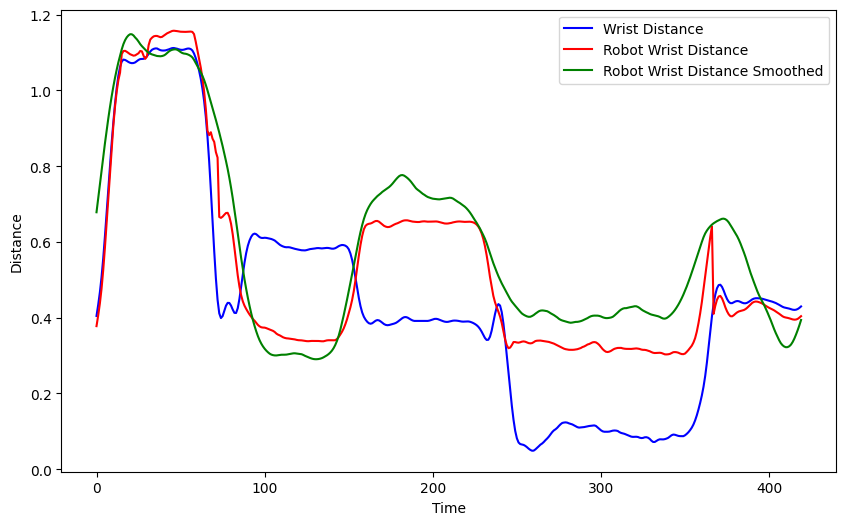

In [244]:
robot_wrist_dist_smoothed_array = np.array(robot_wrist_dist_smoothed_list)

import matplotlib.pyplot as plt

time = np.arange(0, robot_wrist_dist_smoothed_array.shape[0])
plt.figure(figsize=(10, 6))
plt.plot(time, wrist_dist_array, 'b-', label='Wrist Distance')
plt.plot(time, robot_wrist_dist_array, 'r-', label='Robot Wrist Distance')
plt.plot(time, robot_wrist_dist_smoothed_array, 'g-', label='Robot Wrist Distance Smoothed')

plt.xlabel('Time')
plt.ylabel('Distance')
plt.legend()

plt.show()

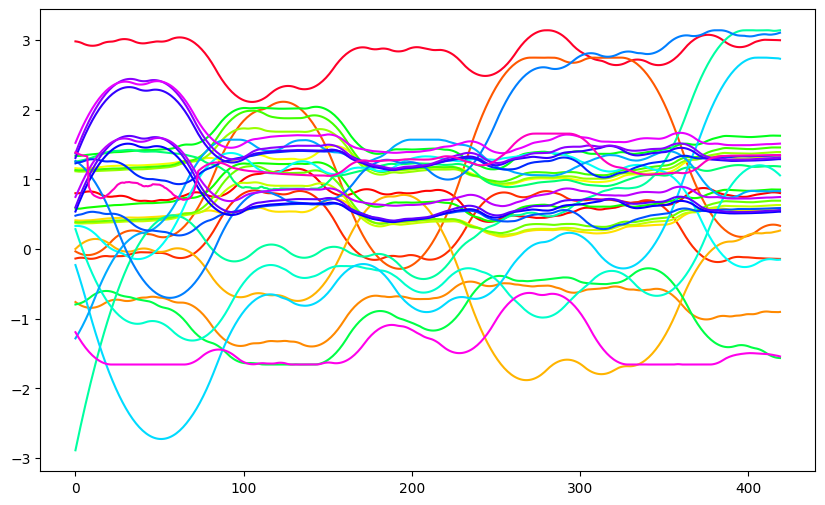

In [245]:
import matplotlib.pyplot as plt

time = np.arange(0,q_robot_export.shape[0])
plt.figure(figsize=(10,6))
cs = [plt.cm.gist_rainbow(x) for x in np.linspace(0,1,q_robot_export.shape[1])]
for i in range(q_robot_array_cf_smoothed.shape[1]):
    plt.plot(time, q_robot_export[:,i], color=cs[i])

In [246]:
# header_name = 'robot1/joint1,robot1/joint2,robot1/joint3,robot1/joint4,robot1/joint5,robot1/joint6,\
#                robot1/index_q1,robot1/index_q2,robot1/middle_q1,robot1/middle_q2,robot1/ring_q1,robot1/ring_q2,robot1/pinky_q1,robot1/pinky_q2,robot1/thumb_q1,robot1/thumb_q2,\
#                robot2/joint1,robot2/joint2,robot2/joint3,robot2/joint4,robot2/joint5,robot2/joint6,\
#                robot2/index_q1,robot2/index_q2,robot2/middle_q1,robot2/middle_q2,robot2/ring_q1,robot2/ring_q2,robot2/pinky_q1,robot2/pinky_q2,robot2/thumb_q1,robot2/thumb_q2'

# np.savetxt(
#     # fname=str(data_numbers[0]) + "_" + str(data_numbers[-1]) + ".csv",
#     fname="dualarms_test.csv",
#     X=q_robot_export[:final_len,:],
#     delimiter=',',
#     # header=header_name,
#     fmt='%.6f'
#     )

In [247]:
smplh_lw_pos_array = np.array(smplh_lw_pos_list)
smplh_rw_pos_array = np.array(smplh_rw_pos_list)

robot_lw_pos_array = np.array(robot_lw_pos_list)
robot_rw_pos_array = np.array(robot_rw_pos_list)

scaled_smplh_lw_pos_array = robot_left_shoulder_pos + (np.array(smplh_lw_pos_list)-smplh_left_shoulder_pos)*robot_arm_length/smplh_arm_length
scaled_smplh_rw_pos_array = robot_right_shoulder_pos + (np.array(smplh_rw_pos_list)-smplh_right_shoulder_pos)*robot_arm_length/smplh_arm_length

scaled_robot_lw_pos_array = smplh_left_shoulder_pos + (np.array(robot_lw_pos_list)-robot_left_shoulder_pos)*smplh_arm_length/robot_arm_length
scaled_robot_rw_pos_array = smplh_right_shoulder_pos + (np.array(robot_rw_pos_list)-robot_right_shoulder_pos)*smplh_arm_length/robot_arm_length

In [248]:
xml_path = '../asset/kimlab_dualarms/scene_dualarms.xml'
env = MuJoCoParserClass(name='Dual Arms',rel_xml_path=xml_path,VERBOSE=False)
env.set_geom_color(
    rgba                = (0.2,0.2,0.2,0.9),
    body_names_to_color = [
        'robot1/end_link','robot1/index_L1','robot1/index_L2','robot1/index_tip',
        'robot1/middle_L1','robot1/middle_L2','robot1/middle_tip',
        'robot1/ring_L1','robot1/ring_L2','robot1/ring_tip',
        'robot1/pinky_L1','robot1/pinky_L2','robot1/pinky_tip',
        'robot1/thumb_L1','robot1/thumb_L2','robot1/thumb_tip',
        'robot2/end_link','robot2/index_L1','robot2/index_L2','robot2/index_tip',
        'robot2/middle_L1','robot2/middle_L2','robot2/middle_tip',
        'robot2/ring_L1','robot2/ring_L2','robot2/ring_tip',
        'robot2/pinky_L1','robot2/pinky_L2','robot2/pinky_tip',
        'robot2/thumb_L1','robot2/thumb_L2','robot2/thumb_tip'],
)

env.init_viewer(viewer_title='Dual-Arm',viewer_width=800,viewer_height=800,
                viewer_hide_menus=True)
env.update_viewer(azimuth=180,distance=2.05,elevation=-20,lookat=[0.02,-0.018,1.4])
env.reset()

PLOT_TRAJ = False
PLOT_LABEL = True
SAVE_VIDEO = True
video = []

plot_tick = 0
line_radius = 0.0015

while plot_tick < final_len and env.is_viewer_alive():
    q_robot = q_robot_array_hand_cf_smoothed[plot_tick,:]
    # q_robot = np.zeros(env.model.nq)
    env.forward(q=q_robot,INCREASE_TICK=True)
    env.plot_T(p=np.zeros(3),R=np.eye(3),label="Tick: [%d/%d]"%(plot_tick,final_len),axis_len=0.5,axis_width=0.005)

    if PLOT_TRAJ == True:
        env.plot_traj_thick(scaled_smplh_lw_pos_array,rgba=[0,1,0,0.35],plot_line=True,plot_sphere=False,line_r=line_radius)
        if PLOT_LABEL: env.plot_T(p=scaled_smplh_lw_pos_array[-1],R=np.eye(3),label="SMPL-H Left Wrist",PLOT_AXIS=False)
        env.plot_traj_thick(scaled_smplh_rw_pos_array,rgba=[0,1,1,0.35],plot_line=True,plot_sphere=False,line_r=line_radius)
        if PLOT_LABEL: env.plot_T(p=scaled_smplh_rw_pos_array[-1],R=np.eye(3),label="SMPL-H Right Wrist",PLOT_AXIS=False)
        
        env.plot_traj_thick(robot_lw_pos_array[:plot_tick],rgba=[1,0,0,1],plot_line=True,plot_sphere=False,line_r=line_radius*2)
        if PLOT_LABEL: env.plot_T(p=robot_lw_pos_array[plot_tick],R=np.eye(3),label="Robot Left Wrist",PLOT_AXIS=False)
        env.plot_traj_thick(robot_rw_pos_array[:plot_tick],rgba=[1,0.5,0,1],plot_line=True,plot_sphere=False,line_r=line_radius*2)
        if PLOT_LABEL: env.plot_T(p=robot_rw_pos_array[plot_tick],R=np.eye(3),label="Robot Right Wrist",PLOT_AXIS=False)
    env.render()
    
    video.append(env.grab_image())
    plot_tick += 1
    if plot_tick == final_len:
        if not SAVE_VIDEO: plot_tick = 0

env.close_viewer()
if SAVE_VIDEO:mediapy.show_video(images=video,fps=15,width=800)

In [249]:
from scipy.spatial import procrustes

# smplh_wrist_array = np.hstack((smplh_lw_pos_array,smplh_rw_pos_array))
# robot_wrist_array = np.hstack((robot_lw_pos_array,robot_rw_pos_array))

# _, _, disparity = procrustes(smplh_wrist_array,robot_wrist_array)
# print(disparity)

la, lb, ld = procrustes(smplh_lw_pos_array,robot_lw_pos_array)
print(ld)

ra, rb, rd = procrustes(smplh_rw_pos_array,robot_rw_pos_array)
print(rd)

0.05064035977816237
0.5680953053872141


In [250]:
import cv2

def angle_error(R1, R2):
    # Convert rotation matrices to rotation vectors
    rvec1, _ = cv2.Rodrigues(R1)
    rvec2, _ = cv2.Rodrigues(R2)
    
    # Calculate the difference between rotation vectors
    rvec_diff = rvec2 - rvec1
    
    # Convert the difference back to a rotation matrix
    R_diff, _ = cv2.Rodrigues(rvec_diff)
    
    # Extract the angle from the rotation matrix
    # The trace of the rotation matrix is equal to 1 + 2 * cos(theta)
    trace = np.trace(R_diff)
    cos_theta = (trace - 1) / 2
    
    # Ensure cos_theta is within valid range due to potential numerical errors
    cos_theta = np.clip(cos_theta, -1, 1)
    
    # Calculate the angle in radians
    angle_rad = np.arccos(cos_theta)
    
    return angle_rad

robot_lw_rot_array = np.array(robot_lw_rot_list)
robot_rw_rot_array = np.array(robot_rw_rot_list)

left_loss = 0
right_loss = 0

for i in range(final_len):
    lw_rot_target = lw_rot_array[i,:] @ rpy2r(np.radians([0,0,90]))
    rw_rot_target = rw_rot_array[i,:] @ rpy2r(np.radians([0,0,-90]))

    robot_lw_rot = robot_lw_rot_array[i,:]
    robot_rw_rot = robot_rw_rot_array[i,:]

    left_error = angle_error(robot_lw_rot, lw_rot_target)
    left_loss += left_error

    right_error = angle_error(robot_rw_rot, rw_rot_target)
    right_loss += right_error

print("Average left error: ", left_loss/final_len)
print("Average right error: ", right_loss/final_len)

Average left error:  0.2518702907494668
Average right error:  1.2625862302192463
